# 1. Import and Install Dependencies

In [ ]:
!pip install mediapipe
!pip install scikit-learn
!pip install seaborn

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time , random
import mediapipe as mp
import copy
import glob
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization,Input,Conv1D,MaxPooling1D,\
                                    TimeDistributed,Activation,Lambda,ReLU,Conv1D,ConvLSTM1D,Flatten
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,confusion_matrix
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import plot_model
import seaborn as sns

# 2. Check GPU Existing

In [11]:

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10875603021319235248
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8566672916616535439
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12526216991396059873
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


# 3. Keypoints using MP Holistic

In [12]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [13]:
def mediapipe_detection(image, model):
    """
    inputs: CV2 Image
    output: Image, detected Landmarks
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable to Improve Perf.
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [14]:
# Draw Landmarks on Image
def draw_landmarks(image, results):
    """
    inputs: CV2 Image , Landmarks[Model Results]
    """
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [15]:
# Draw Styled Landmarks on Image
def draw_styled_landmarks(image, results):
    """
    inputs: CV2 Image , Landmarks[Model Results]
    """
    # Draw face connections

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

# 4. Extract Keypoint Values

In [16]:
# Extract Keypoints from Landmarks And Concatenate it in One Array
def extract_keypoints(results):
    """
    inputs: Resutls from MediaPipe Model
    output: Concatenated Landmarks
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 5. Setup Folders for Collection

In [17]:
actions = np.array(['drink','eat','friend','goodbye','hello','help','how are you','no','yes','please','sorry','thanks','cry','i','they','you','what','name','teacher','family','happy','love','sad','laugh','neighbor','ok','read','write','school'])
print(len(actions))

29


# 6. Preprocess Data and Create Labels and Features

In [18]:
# Labeling Actions to Numbers
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

# 7. Load All Data




In [ ]:
# Upload final_data (Colab)
# Note that if your training is done on kaggle, so ignore this cell and upload data on kaggle instead

!unzip /content/drive/MyDrive/grad/final_data.zip -d '/content/drive/MyDrive/grad/final_data'

Archive:  /content/drive/MyDrive/grad/final_data.zip

replace /content/drive/MyDrive/grad/final_data/30FPS/cry/1/0.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# working on kaggle
ROOT = "/kaggle/input/"
DATA_PATH_KEYPOINTS = os.join(ROOT, "final-data")

In [ ]:

# Load Data 60 fps then Transform it to 30fps
sequences1, labels1 = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'60FPS',action,'*']))
    for sequence in list_seq:
        window = []
        # Take two Steps to Convert it To 30FPS
        for frame_num in range(0,60,2):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(sequence, "{}.npy".format(frame_num)))
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences1.append(window)
        labels1.append(label_map[action])
    print(f'action: {action} done.')

In [21]:
#Convert Lists To Array
X2 = np.array(sequences1)
#Convert Labels to OHE
y2 = to_categorical(labels1).astype(int)
X2.shape, y2.shape

((1711, 30, 84), (1711, 29))

In [22]:
# Load 30 Fps Data Folder
# DATA_PATH_KEYPOINTS = os.path.join('/content/drive/MyDrive/sign_lan/FINAL_DATA')
sequences, labels = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'30FPS',action,'*']))
    for sequence in list_seq:
        window = []
        for frame_num in range(0,30):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(str(sequence), "{}.npy".format(frame_num)))
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences.append(window)
        labels.append(label_map[action])

In [23]:
#Convert Lists To Array
X1 = np.array(sequences)
#Convert Labels to OHE
y1 = to_categorical(labels).astype(int)
X1.shape, y1.shape


((2871, 30, 84), (2871, 29))

In [24]:
# concatenate all data
X = np.concatenate([X1,X2])
y = np.concatenate([y1,y2])
X.shape,y.shape

((4582, 30, 84), (4582, 29))

# 8. Data Augmentation

In [25]:
# Rotation Augmentation
def augment_data_rotataion(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape:[Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)

    #Looping in all Examples
    for ex in range(X.shape[0]):
        # Get Random Angle Betwwen -5,5
        rotation_angle = random.randint(-5,5)
        # Convert it to Radians
        theta = np.radians(rotation_angle)
        c, s = np.cos(theta), np.sin(theta)
        # Build a Rotation Matrix
        rotation_matrix = np.array(((c, -s), (s, c)))
        # Looping Each Frame
        for frame in range(X.shape[1]):
            window = []
            # looping each Point within Frame
            for i in range(0,X.shape[2]-1,2):
                # Get Keypoint
                keypoint = np.array([X[ex][frame][i],X[ex][frame][i+1]])
                # Calculate Rotated Keypoint
                rotated_keypoint = np.dot(rotation_matrix, keypoint)
                keypoint_x = rotated_keypoint[0]
                keypoint_y = rotated_keypoint[1]
                # Append New Keypoint To our Data
                window.extend([keypoint_x,keypoint_y])
            augmented_X[ex][frame] = np.array(window)
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [26]:
# Scale Augmentation
def augment_data_scale(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape: [Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)
    # Looping in Each Sample
    for ex in range(X.shape[0]):
        # Get Random Scale Factor
        SCALE = round(random.random(),2)
        for frame in range(X.shape[1]):
            # Calculate New Point
            augmented_X[ex][frame] = X[ex][frame]*SCALE
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [27]:
# Augmented Rotated Data
rot_x,rot_y = augment_data_rotataion(X,y)
# Augmented Scaled Data
scaled_x,scaled_y = augment_data_scale(X,y)

In [28]:
# concatenate all data [Original and Augmented]
X_ = np.concatenate([X,rot_x,scaled_x])
y_ = np.concatenate([y,rot_y,scaled_y])
X_.shape,y_.shape

((13746, 30, 84), (13746, 29))

In [29]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.20,shuffle=True,stratify=y_,random_state=42)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10996, 30, 84), (2750, 30, 84), (10996, 29), (2750, 29))

# 9. Build and Train Transeormer Model

In [31]:
# Define The Time Steps
timesteps = X.shape[1]
# Define The Features No.
features = X.shape[2]

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

## 9.1 Data Generator(On Fly)

In [33]:
def data_generator(X, y, batch_size):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            yield batch_X, batch_y

In [34]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(actions.shape[0], activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [35]:
input_shape = X_train.shape[1:]

In [ ]:
model_transformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
model_transformer.summary()

In [37]:
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["categorical_accuracy"],
)

In [38]:
log_dir = os.path.join('Logs/transformer_encoder')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
# mc = ModelCheckpoint('Models/model_transformer_encoder.h5', monitor='val_categorical_accuracy', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,patience=100)
callbacks = [tb_callback,es]

In [39]:

batch_size = 8
# Create instances of data generators
train_data_generator = data_generator(X_train, y_train, batch_size)
val_data_generator = data_generator(X_test, y_test, batch_size)

# Train the model using a custom training loop with data generators
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

In [40]:

history_model_transformer = model_transformer.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=1000,
    validation_data=val_data_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/1000


I0000 00:00:1720054645.778448     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720054645.814366     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.816347     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.817533     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.818626     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.820690     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.821611     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054645.822647     158 graph_launch.cc:671] Fallback to op-by-op mode because m

1368/1374 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.0441 - loss: 3.3361

W0000 00:00:1720054658.572471     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054658.573813     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054658.574785     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054658.575677     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1374/1374 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - categorical_accuracy: 0.0441 - loss: 3.3358 - val_categorical_accuracy: 0.0652 - val_loss: 3.1126
Epoch 2/1000
  16/1374 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - categorical_accuracy: 0.0601 - loss: 3.1911    

W0000 00:00:1720054686.822931     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.824477     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.825692     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.826831     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.828481     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.829270     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.830452     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054686.832333     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1370/1374 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.0656 - loss: 3.1301

W0000 00:00:1720054699.245673     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054699.246893     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054699.247876     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720054699.248815     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1374/1374 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - categorical_accuracy: 0.0656 - loss: 3.1299 - val_categorical_accuracy: 0.0689 - val_loss: 2.8872
Epoch 3/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical_accuracy: 0.0694 - loss: 2.9963 - val_categorical_accuracy: 0.0718 - val_loss: 2.8024
Epoch 4/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical_accuracy: 0.0743 - loss: 2.9250 - val_categorical_accuracy: 0.0988 - val_loss: 2.7458
Epoch 5/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical_accuracy: 0.0777 - loss: 2.8742 - val_categorical_accuracy: 0.0846 - val_loss: 2.7071
Epoch 6/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical_accuracy: 0.0771 - loss: 2.8387 - val_categorical_accuracy: 0.0795 - val_loss: 2.6951
Epoch 7/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - categorical_accuracy: 0.0794 - loss: 2.8140 - val_categorical_accuracy: 0.0791 - val_loss: 2.6587
Epoch 8/1000
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical

In [47]:
model_transformer.save("model_transformer_12.h5")

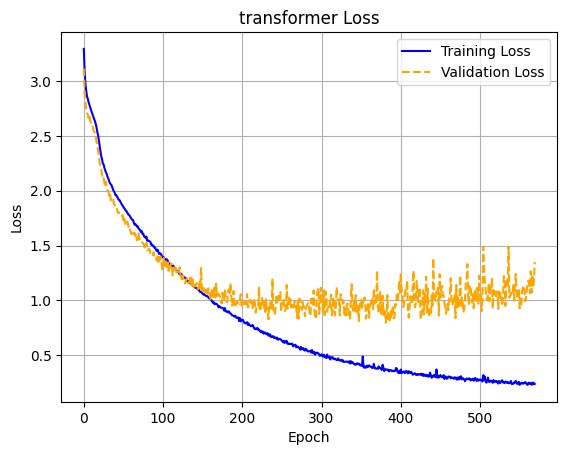

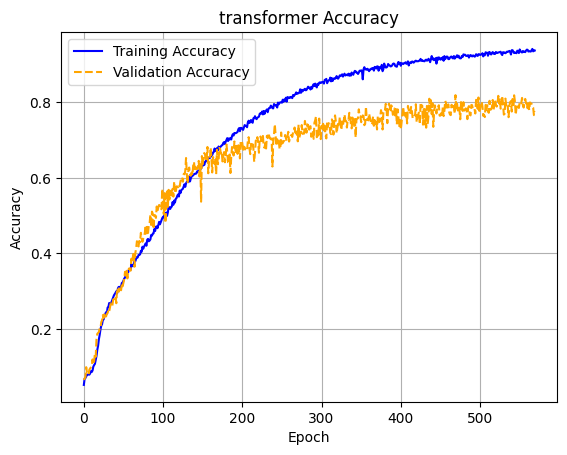

In [48]:
# Plot training & validation loss values
plt.plot(history_model_transformer.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history_model_transformer.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('transformer Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
print("")
# Plot training & validation accuracy values
plt.plot(history_model_transformer.history['categorical_accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history_model_transformer.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('transformer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [49]:
model_transformer.evaluate(X_test, y_test, verbose=1)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7745 - loss: 1.3327


[1.3303695917129517, 0.7803636193275452]